# POC 2 : Mask2Former on Cityscape dataset

## Import

In [1]:
 from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model/

Mounted at /content/drive
/content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model


In [2]:
!pip install -q mlflow
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.8 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from collections import Counter

import mlflow
import mlflow.pytorch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
from torch.amp import autocast

import segmentation_models_pytorch as smp


import torchvision.models as models
import torch.nn.functional as F
import torchvision

import torchvision.models.segmentation as models
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

import os, cv2, random, numpy as np
from glob import glob

from torch.utils.data import Subset

torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name()

# !pip install -U transformers timm accelerate einops

import os, math, random, time, json
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt

from transformers import (
    Mask2FormerImageProcessor,
    Mask2FormerForUniversalSegmentation,
)

import random, csv, torch
from pathlib import Path

import torch
import torch.nn.functional as F
import mlflow
import time
from pathlib import Path
from torch.cuda.amp import GradScaler, autocast
import gc

import torch
import matplotlib.pyplot as plt
import numpy as np



In [4]:
CITYSCAPES_ROOT = "./data"

LEFTIMG_DIR = os.path.join(CITYSCAPES_ROOT, "leftImg8bit")
MASK_DIR    = os.path.join(CITYSCAPES_ROOT, "gtFine")

TRAIN_IMG_DIR = os.path.join(LEFTIMG_DIR, "train")
VAL_IMG_DIR   = os.path.join(LEFTIMG_DIR, "val")
TEST_IMG_DIR  = os.path.join(LEFTIMG_DIR, "test")

TRAIN_MASK_DIR = os.path.join(MASK_DIR, "train")
VAL_MASK_DIR   = os.path.join(MASK_DIR, "val")
TEST_MASK_DIR  = os.path.join(MASK_DIR, "test")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 8
IMG_WIDTH, IMG_HEIGHT = 512, 256
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16



(True, 0, 'Tesla T4')

## Class remapping and resizing


In [5]:
# Mapping class ID
CITYSCAPES_8_CLASSES = {
        7: 0, 8: 0, 9: 7, 10: 7,
        24: 1, 25: 1,
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,
        18: 4, 19: 4, 20: 4,
        21: 5, 22: 5,
        23: 6,
}

def remap_mask(mask):
    """
    Remap the original Cityscapes mask classes to a reduced set of 8 target classes.

    This function takes an input mask where pixel values correspond to the
    original Cityscapes class labels, and replaces them with a new label set
    defined in the CITYSCAPES_8_CLASSES dictionary.

    Args:
        mask (PIL.Image.Image or np.ndarray): Input segmentation mask.

    Returns:
        np.ndarray: Remapped mask with class values ranging from 0 to 7 (int64).
    """
    mask_array = np.array(mask)
    new_mask = np.zeros_like(mask_array)

    for k, v in CITYSCAPES_8_CLASSES.items():
        new_mask[mask_array == k] = v

    return new_mask.astype(np.int64)

##Image Preprocessing

In [6]:
random.seed(42)

R = 256
ROOT_RAW = CITYSCAPES_ROOT
OUT = "data/Cityscapes_resized_256"

def flat_mapping_from_dict(d):
    m = {}
    for k,v in d.items():
        m[int(k)] = int(v)
    return m

#MAPPING = flat_mapping_from_dict(CITYSCAPES_8_CLASSES)
#IGNORE = 255

def remap_mask_ids(mask_np):
    """
    Remap the original Cityscapes label IDs to a reduced set of 8 classes.
    Returns a new mask with remapped class indices.
    """
    out = np.full_like(mask_np, IGNORE, dtype=np.int64)
    for k, v in MAPPING.items():
        out[mask_np == k] = v
    return out


def resize_by_height(img, lbl, target_height=256):
    """
    Resize both image and label to a target height while preserving aspect ratio.
    Returns the resized image and resized label.
    """
    h, w = img.shape[:2]
    scale = target_height / h
    new_w = int(w * scale)
    img_resized = cv2.resize(img, (new_w, target_height), interpolation=cv2.INTER_LINEAR)
    lbl_resized = cv2.resize(lbl, (new_w, target_height), interpolation=cv2.INTER_NEAREST)
    return img_resized, lbl_resized


def list_pairs(img_root, lbl_root):
    """
    Match each leftImg8bit image with its corresponding gtFine label.
    Returns a list of (image_path, label_path) pairs.
    """
    imgs = sorted(glob(os.path.join(img_root, "*", "*_leftImg8bit.png")))
    pairs = []
    for p in imgs:
        city = p.split(os.sep)[-2]
        stem = os.path.basename(p).replace("_leftImg8bit.png", "")
        lbl = os.path.join(lbl_root, city, stem + "_gtFine_labelIds.png")
        if os.path.exists(lbl):
            pairs.append((p, lbl))
    return pairs

#LEFT = os.path.join(ROOT_RAW, "leftImg8bit")
#GT   = os.path.join(ROOT_RAW, "gtFine")

#train_pairs = list_pairs(os.path.join(LEFT,"train"), os.path.join(GT,"train"))[:300]
#val_pairs   = list_pairs(os.path.join(LEFT,"val"),   os.path.join(GT,"val"))[:20]

def save_pair(split, city, stem, img_resized, lbl_resized):
    """
    Save one resized image/label pair inside the output directory.
    """
    os.makedirs(os.path.join(OUT, "images", split), exist_ok=True)
    os.makedirs(os.path.join(OUT, "labels", split), exist_ok=True)
    out_img = os.path.join(OUT, "images", split, f"{city}_{stem}.png")
    out_lbl = os.path.join(OUT, "labels", split, f"{city}_{stem}.png")
    cv2.imwrite(out_img, img_resized)
    cv2.imwrite(out_lbl, lbl_resized.astype(np.uint8))


def process_split(pairs, split):
    """
    Process all image/label pairs: load, remap IDs, resize, and save to disk.
    """
    print(f"Génération {split}… ({len(pairs)} images)")
    for ip, lp in pairs:
        img = cv2.imread(ip, cv2.IMREAD_COLOR)
        lbl = cv2.imread(lp, cv2.IMREAD_UNCHANGED)
        lbl = remap_mask_ids(lbl)
        img_r, lbl_r = resize_by_height(img, lbl, R)
        city = ip.split(os.sep)[-2]
        stem = os.path.basename(ip).replace("_leftImg8bit.png", "")
        save_pair(split, city, stem, img_r, lbl_r)

#process_split(train_pairs, "train")
#process_split(val_pairs, "val")

print(f"✅ OK: {OUT} prêt")


✅ OK: data/Cityscapes_resized_256 prêt


In [8]:
CITYSCAPES_ROOT = "./data"
OUT = "data/Cityscapes_resized_256"
IMG_SIZE = (256, None)
NUM_CLASSES = 8
IGNORE_INDEX = 255
BATCH_SIZE = 4
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


CITYSCAPES_8_CLASSES = {
    7:0, 8:0, 9:7, 10:7,
    24:1, 25:1,
    26:2, 27:2, 28:2, 29:2, 30:2, 31:2, 32:2, 33:2,
    11:3, 12:3, 13:3, 14:3, 15:3, 16:3, 17:4,
    18:4, 19:4, 20:4,
    21:5, 22:5,
    23:6
}

id2label = {i: n for i, n in enumerate([
    "sol/flat","humain","vehicule","construction","objet","nature","ciel","rail"
])}
label2id = {v:k for k,v in id2label.items()}
palette = np.array([
    [128, 64,128],
    [220, 20, 60],
    [ 70, 70, 70],
    [ 70,130,180],
    [  0,  0,142],
    [107,142, 35],
    [ 70,130,180],
    [ 90, 90, 90],
], dtype=np.uint8)


## Train / Val split for small and full dataset

In [11]:

class City8Dataset(Dataset):
    """Custom dataset for Cityscapes reduced to 8 classes.
    Loads RGB images and their label maps, applies normalization,
    extracts binary masks per class, and returns all fields required by Mask2Former.
    """

    def __init__(self, root, split, processor=None):
        self.img_dir = os.path.join(root, "images", split)
        self.lbl_dir = os.path.join(root, "labels", split)
        self.imgs = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        self.processor = processor
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __len__(self):
        """Returns the number of images available in the dataset."""
        return len(self.imgs)

    def __getitem__(self, idx):
        """Reads one sample: image, label, class masks, and class IDs.
        Returns a dictionary matching Mask2Former training format.
        """
        name = self.imgs[idx]
        img = Image.open(os.path.join(self.img_dir, name)).convert("RGB")
        lbl = Image.open(os.path.join(self.lbl_dir, name)).convert("L")
        lbl_np = np.array(lbl, dtype=np.uint8)

        x = self.normalize(self.to_tensor(img))
        pixel_mask = torch.ones((lbl_np.shape[0], lbl_np.shape[1]), dtype=torch.long)

        classes_present = sorted([int(c) for c in np.unique(lbl_np) if c != IGNORE_INDEX])

        mask_labels = []
        class_labels = []
        for c in classes_present:
            m = (lbl_np == c).astype(np.int64)
            if m.sum() == 0:
                continue
            mask_labels.append(torch.from_numpy(m))
            class_labels.append(c)

        sample = {
            "pixel_values": x,
            "pixel_mask": pixel_mask,
            "mask_labels": mask_labels,
            "class_labels": torch.tensor(class_labels, dtype=torch.long),
            "name": name,
            "orig_lbl": torch.from_numpy(lbl_np),
        }
        return sample


def collate_fn(batch):
    """Batch collation for Mask2Former.
    Stacks pixel values and pixel masks, keeps mask lists untouched,
    and copies class labels and metadata.
    """
    out = {}
    out["pixel_values"] = torch.stack([b["pixel_values"] for b in batch], dim=0)
    out["pixel_mask"] = torch.stack([b["pixel_mask"] for b in batch], dim=0)
    out["mask_labels"] = [b["mask_labels"] for b in batch]
    out["class_labels"] = [b["class_labels"] for b in batch]
    out["name"] = [b["name"] for b in batch]
    out["orig_lbl"] = [b["orig_lbl"] for b in batch]
    return out


processor = Mask2FormerImageProcessor(do_resize=False, do_normalize=False)

train_set = City8Dataset(OUT, "train", processor)
val_set   = City8Dataset(OUT, "val", processor)

train_indices_small = list(range(300))
val_indices_small   = list(range(50))

train_ds_small = Subset(train_set, train_indices_small)
val_ds_small   = Subset(val_set,   val_indices_small)

train_dl_small = DataLoader(train_ds_small, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
val_dl_small   = DataLoader(val_ds_small,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)

print(f"Train: {len(train_ds_small)} | Val: {len(val_ds_small)}")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)

print(f"Train: {len(train_set)}  |  Val: {len(val_set)}")


Train: 300 | Val: 50
Train: 2975  |  Val: 500


## Load Model

In [12]:
checkpoint = "facebook/mask2former-swin-small-coco-panoptic"
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint,
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to(DEVICE)
print("Modèle prêt :", type(model).__name__)
from transformers import Mask2FormerImageProcessor
processor = Mask2FormerImageProcessor.from_pretrained(checkpoint, reduce_labels=False)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle prêt : Mask2FormerForUniversalSegmentation


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [13]:
def fast_confmat(num_classes, preds, gts, ignore=IGNORE_INDEX):
    """Computes a confusion matrix for segmentation predictions.
    Args:
        num_classes: number of target classes.
        preds: list of predicted maps [H, W].
        gts: list of ground-truth maps [H, W].
        ignore: class index to ignore in evaluation.
    Returns:
        A tensor [num_classes, num_classes] representing the confusion matrix.
    """
    conf = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for p, g in zip(preds, gts):
        g = g.view(-1)
        p = p.view(-1)
        m = g != ignore
        g = g[m]
        p = p[m]
        k = (g * num_classes + p).to(torch.int64)
        binc = torch.bincount(k, minlength=num_classes * num_classes)
        conf += binc.view(num_classes, num_classes)
    return conf


def miou_from_conf(conf):
    """Computes mIoU and per-class IoU from a confusion matrix.
    Args:
        conf: confusion matrix [C, C].
    Returns:
        mIoU (float) and list of IoU per class.
    """
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = (tp + fp + fn).clamp(min=1)
    iou = tp.float() / denom.float()
    miou = iou.mean().item()
    return miou, iou.tolist()


@torch.no_grad()
def logits_to_seg(logits):
    """Converts raw logits [B, C, H, W] into segmentation maps [B, H, W]."""
    return logits.argmax(1)


@torch.no_grad()
def evaluate(model, loader):
    """Evaluates a segmentation model using mIoU.
    Args:
        model: trained model.
        loader: validation dataloader.
    Returns:
        mIoU and list of per-class IoU values.
    """
    model.eval()
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64)

    for batch in loader:
        x = batch["pixel_values"].to(DEVICE)
        pixel_mask = batch["pixel_mask"].to(DEVICE)

        with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda"), dtype=torch.float16):
            outputs = model(pixel_values=x, pixel_mask=pixel_mask)

        target_sizes = [t.shape for t in batch["orig_lbl"]]
        target_sizes = [(int(h), int(w)) for (h, w) in target_sizes]

        segs = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

        preds = [s.to("cpu").to(torch.int64) for s in segs]
        gts = [t for t in batch["orig_lbl"]]

        conf += fast_confmat(NUM_CLASSES, preds, gts, ignore=IGNORE_INDEX)

    miou, perclass = miou_from_conf(conf)
    return miou, perclass


In [14]:
def colorize(lbl_np):
    """Converts a label mask [H, W] into a colorized RGB mask using the global palette.
    Args:
        lbl_np: numpy array of shape [H, W] with class indices.
    Returns:
        A numpy array [H, W, 3] containing the colorized mask.
    """
    out = np.zeros((lbl_np.shape[0], lbl_np.shape[1], 3), dtype=np.uint8)
    m = lbl_np != IGNORE_INDEX
    out[m] = palette[lbl_np[m]]
    return out


@torch.no_grad()
def show_triplet(model, dataset, idx=0):
    """Displays an image, its ground truth mask, and the model prediction side by side.
    Args:
        model: trained segmentation model.
        dataset: dataset providing samples.
        idx: index of the sample to visualize.
    """
    sample = dataset[idx]
    x = sample["pixel_values"].unsqueeze(0).to(DEVICE)
    pixel_mask = sample["pixel_mask"].unsqueeze(0).to(DEVICE)

    with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda"), dtype=torch.float16):
        outputs = model(pixel_values=x, pixel_mask=pixel_mask)

    H, W = sample["orig_lbl"].shape
    pred = processor.post_process_semantic_segmentation(outputs, target_sizes=[(H, W)])[0]
    pred = pred.to("cpu").numpy().astype(np.uint8)

    img = (sample["pixel_values"].permute(1,2,0).cpu().numpy()
           * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
    img = np.clip(img, 0, 1)

    gt = sample["orig_lbl"].numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(colorize(gt)); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(colorize(pred)); plt.title("Prediction"); plt.axis("off")
    plt.show()


In [15]:
def _stack_targets(batch):
    """
    Convert a batch of variable-length binary masks into consistent tensors.
    Each item contains a list of binary masks [H,W] and class labels.
    This function stacks them into:
        - masks_b: tensor of shape (B, N, H, W) as float32
        - classes_b: tensor of shape (B, N) with class indices
    Returns:
        masks_b (torch.Tensor), classes_b (torch.Tensor)
    """
    masks_b = []
    classes_b = []

    H, W = batch["orig_lbl"][0].shape  # all images have same size
    for m_list, c in zip(batch["mask_labels"], batch["class_labels"]):
        if len(m_list) == 0:
            masks_b.append(torch.zeros((0, H, W), dtype=torch.float32, device=DEVICE))
            classes_b.append(torch.empty((0,), dtype=torch.long, device=DEVICE))
        else:
            m = torch.stack([m.to(torch.float32) for m in m_list], dim=0).to(DEVICE)  # (N,H,W)
            masks_b.append(m)
            classes_b.append(torch.tensor(c, dtype=torch.long).to(DEVICE))

    return masks_b, classes_b


def train_one_epoch(model, loader, optim):
    """
    Train the model for a single epoch.
    Args:
        model: Mask2Former model
        loader: training dataloader
        optim: optimizer
    Returns:
        average training loss for this epoch (float)
    """
    model.train()
    total = 0.0

    for batch in loader:
        x = batch["pixel_values"].to(DEVICE)
        pixel_mask = batch["pixel_mask"].to(DEVICE)
        mask_labels, class_labels = _stack_targets(batch)

        optim.zero_grad(set_to_none=True)
        with autocast(enabled=(DEVICE=="cuda"), dtype=torch.float16):
            out = model(
                pixel_values=x,
                pixel_mask=pixel_mask,
                mask_labels=mask_labels,
                class_labels=class_labels,
            )
            loss = out.loss

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()

        total += loss.item()

    if DEVICE == "cuda":
        torch.cuda.empty_cache()

    return total / max(1, len(loader))



def fit(model, train_loader, val_loader, epochs=5, lr=2e-5, wd=0.01):
    """
    Full training loop for Mask2Former.
    Args:
        model: segmentation model
        train_loader: dataloader for training
        val_loader: dataloader for validation
        epochs: number of training epochs
        lr: learning rate
        wd: weight decay
    Returns:
        best validation mIoU obtained during training (float)
    """
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    best = -1.0

    for e in range(1, epochs+1):
        t0 = time.time()

        loss = train_one_epoch(model, train_loader, optim)
        miou, perclass = evaluate(model, val_loader)

        dt = time.time() - t0
        print(f"[Epoch {e}/{epochs}] perte={loss:.4f} | mIoU={miou:.4f} | temps={dt:.1f}s")

        if miou > best:
            best = miou
            torch.save(model.state_dict(), "mask2former_best_8cls.pt")
            print("✓ Nouveau meilleur modèle sauvegardé")

    print(f"Entraînement terminé. Meilleure mIoU: {best:.4f}")
    return best



/tmp/ipython-input-190522398.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=="cuda"))


## Search hyper parameters

In [16]:
def _train_eval_once(make_model, train_loader, val_loader, cfg, seed=42):
    """
    Train a temporary model for a single hyperparameter configuration
    and return its validation performance and state dict.
    Args:
        make_model: function that constructs a new model instance
        train_loader: dataloader for training subset
        val_loader: dataloader for validation subset
        cfg: dict containing hyperparameters (lr, wd, epochs)
        seed: random seed for reproducibility
    Returns:
        best_miou (float), best_state (dict) containing model weights
    """
    torch.manual_seed(seed)
    model = make_model().to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
    best = -1.0
    best_state = None

    for e in range(1, cfg["epochs"] + 1):
        loss = train_one_epoch(model, train_loader, optim)
        out = evaluate(model, val_loader)
        miou = out[0] if isinstance(out, tuple) else out
        print(f"[Essai] {e}/{cfg['epochs']} | perte={loss:.4f} | mIoU={miou:.4f}")

        if miou > best:
            best = miou
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}

    return best, best_state

def _sample_cfg(rng):
    """
    Sample a random hyperparameter configuration from predefined ranges.
    Args:
        rng: random number generator
    Returns:
        cfg (dict) containing lr, wd, epochs
    """
    return {
        "lr": 10**rng.uniform(-6, -3.3),
        "wd": 10**rng.uniform(-6, -2),
        "epochs": 10,
    }


def random_search_mask2former(
    make_model, train_loader, val_loader,
    n_trials=12, seed=42,
    save_path="best_mask2former_randomsearch.pt",
    csv_path="mask2former_randomsearch.csv"
):
    """
    Perform a random search over hyperparameters for Mask2Former.
    Args:
        make_model: function that constructs a new model instance
        train_loader: dataloader for training subset
        val_loader: dataloader for validation subset
        n_trials: number of random configurations tested
        seed: random seed for reproducibility
        save_path: file where the best model will be saved
        csv_path: CSV file where all trial results will be logged
    Returns:
        best_m (float): best validation mIoU
        best_cfg (dict): best hyperparameter configuration
        best_state (dict): best model state dict
    """
    rng = random.Random(seed)
    results = []
    best_m, best_cfg, best_state = -1.0, None, None

    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["trial", "lr", "wd", "epochs", "val_mIoU"])

        for t in range(1, n_trials + 1):
            cfg = _sample_cfg(rng)
            print(f"[Essai {t}/{n_trials}] - {cfg}")

            val_m, state = _train_eval_once(make_model, train_loader, val_loader, cfg, seed=seed)
            results.append((val_m, cfg))

            w.writerow([t, cfg["lr"], cfg["wd"], cfg["epochs"], val_m])

            if val_m > best_m:
                best_m, best_cfg, best_state = val_m, cfg, state
                torch.save(best_state, save_path)
                print(f"✔ Nouveau meilleur modèle sauvegardé: {save_path}")

    results.sort(key=lambda x: x[0], reverse=True)
    print("\nTop 5 des configurations:")
    for i, (m, c) in enumerate(results[:5], 1):
        print(f"{i}. mIoU={m:.4f} | {c}")

    print(f"Meilleur config: {best_cfg}")
    print(f"Fichier sauvegardé: {Path(csv_path).resolve()}")

    return best_m, best_cfg, best_state


In [17]:
def make_model():
    """
    Create and return a new Mask2Former model instance for universal segmentation,
    initialized from the pretrained Swin-Small COCO panoptic checkpoint, with the
    number of labels adapted to the 8-class Cityscapes setup.
    Returns:
        Mask2FormerForUniversalSegmentation: a fresh model ready for training
    """
    return Mask2FormerForUniversalSegmentation.from_pretrained(
        "facebook/mask2former-swin-small-coco-panoptic",
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True,
    )


results, best = random_search_mask2former(
    make_model, train_dl_small, val_dl_small, n_trials=10
)


Essai 1/10 – {'lr': 5.3266278548451836e-05, 'wd': 1.2590501261927494e-06, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-190522398.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda"), dtype=torch.float16):
/tmp/ipython-input-4144877541.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is 

[Essai] époque 1/10 | perte=46.9066 | mIoU=0.6849
[Essai] époque 2/10 | perte=28.2363 | mIoU=0.7064
[Essai] époque 3/10 | perte=24.2805 | mIoU=0.6911
[Essai] époque 4/10 | perte=22.1717 | mIoU=0.6930
[Essai] époque 5/10 | perte=20.8635 | mIoU=0.6919
[Essai] époque 6/10 | perte=19.9675 | mIoU=0.7138
[Essai] époque 7/10 | perte=18.2973 | mIoU=0.7062
[Essai] époque 8/10 | perte=17.3741 | mIoU=0.7091
[Essai] époque 9/10 | perte=16.5627 | mIoU=0.7065
[Essai] époque 10/10 | perte=15.9678 | mIoU=0.7130
✅ Nouveau meilleur modèle sauvegardé: best_mask2former_randomsearch.pt

Essai 2/10 – {'lr': 5.528141611428153e-06, 'wd': 7.813452073384152e-06, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=68.0644 | mIoU=0.3907
[Essai] époque 2/10 | perte=53.2951 | mIoU=0.5996
[Essai] époque 3/10 | perte=45.8066 | mIoU=0.6472
[Essai] époque 4/10 | perte=41.0195 | mIoU=0.6664
[Essai] époque 5/10 | perte=37.4618 | mIoU=0.6746
[Essai] époque 6/10 | perte=34.7540 | mIoU=0.6818
[Essai] époque 7/10 | perte=32.5264 | mIoU=0.6931
[Essai] époque 8/10 | perte=30.7416 | mIoU=0.6970
[Essai] époque 9/10 | perte=29.3918 | mIoU=0.6960
[Essai] époque 10/10 | perte=28.2047 | mIoU=0.7007

Essai 3/10 – {'lr': 9.738056236716073e-05, 'wd': 0.0005090939660799937, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=38.0077 | mIoU=0.6783
[Essai] époque 2/10 | perte=26.1869 | mIoU=0.6908
[Essai] époque 3/10 | perte=22.9366 | mIoU=0.6951
[Essai] époque 4/10 | perte=20.5438 | mIoU=0.6925
[Essai] époque 5/10 | perte=18.7883 | mIoU=0.7061
[Essai] époque 6/10 | perte=17.6267 | mIoU=0.7113
[Essai] époque 7/10 | perte=16.3260 | mIoU=0.7099
[Essai] époque 8/10 | perte=15.7104 | mIoU=0.7173
[Essai] époque 9/10 | perte=15.1016 | mIoU=0.7046
[Essai] époque 10/10 | perte=14.8692 | mIoU=0.7175
✅ Nouveau meilleur modèle sauvegardé: best_mask2former_randomsearch.pt

Essai 4/10 – {'lr': 0.00025638040709788113, 'wd': 2.2271800642020374e-06, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=36.1856 | mIoU=0.5625
[Essai] époque 2/10 | perte=26.1019 | mIoU=0.6867
[Essai] époque 3/10 | perte=22.8934 | mIoU=0.6710
[Essai] époque 4/10 | perte=20.8664 | mIoU=0.6417
[Essai] époque 5/10 | perte=20.1486 | mIoU=0.6791
[Essai] époque 6/10 | perte=18.9589 | mIoU=0.6929
[Essai] époque 7/10 | perte=18.2159 | mIoU=0.6370
[Essai] époque 8/10 | perte=18.0816 | mIoU=0.6812
[Essai] époque 9/10 | perte=16.6398 | mIoU=0.6870
[Essai] époque 10/10 | perte=15.9697 | mIoU=0.6879

Essai 5/10 – {'lr': 1.3778086696309695e-05, 'wd': 1.3157969572072436e-06, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=57.0873 | mIoU=0.6205
[Essai] époque 2/10 | perte=39.7654 | mIoU=0.6720
[Essai] époque 3/10 | perte=32.9121 | mIoU=0.6919
[Essai] époque 4/10 | perte=29.0812 | mIoU=0.6971
[Essai] époque 5/10 | perte=26.9082 | mIoU=0.7021
[Essai] époque 6/10 | perte=25.1475 | mIoU=0.7074
[Essai] époque 7/10 | perte=23.7775 | mIoU=0.7026
[Essai] époque 8/10 | perte=22.9219 | mIoU=0.7173
[Essai] époque 9/10 | perte=22.1301 | mIoU=0.6967
[Essai] époque 10/10 | perte=21.6756 | mIoU=0.7098

Essai 6/10 – {'lr': 3.8933417952690386e-06, 'wd': 0.00010505607048113504, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=70.9921 | mIoU=0.3100
[Essai] époque 2/10 | perte=56.7764 | mIoU=0.5585
[Essai] époque 3/10 | perte=49.5755 | mIoU=0.5947
[Essai] époque 4/10 | perte=44.6748 | mIoU=0.6507
[Essai] époque 5/10 | perte=41.0063 | mIoU=0.6669
[Essai] époque 6/10 | perte=38.1969 | mIoU=0.6719
[Essai] époque 7/10 | perte=35.8664 | mIoU=0.6763
[Essai] époque 8/10 | perte=34.0259 | mIoU=0.6814
[Essai] époque 9/10 | perte=32.4561 | mIoU=0.6914
[Essai] époque 10/10 | perte=31.1115 | mIoU=0.6947

Essai 7/10 – {'lr': 1.1793619668688019e-06, 'wd': 6.2423857534094846e-06, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=77.8286 | mIoU=0.1716
[Essai] époque 2/10 | perte=71.1947 | mIoU=0.2072
[Essai] époque 3/10 | perte=65.7452 | mIoU=0.2864
[Essai] époque 4/10 | perte=60.6463 | mIoU=0.3663
[Essai] époque 5/10 | perte=57.6283 | mIoU=0.4798
[Essai] époque 6/10 | perte=55.3425 | mIoU=0.5279
[Essai] époque 7/10 | perte=53.1198 | mIoU=0.5667
[Essai] époque 8/10 | perte=51.2793 | mIoU=0.5833
[Essai] époque 9/10 | perte=49.4470 | mIoU=0.5945
[Essai] époque 10/10 | perte=47.8899 | mIoU=0.6099

Essai 8/10 – {'lr': 5.684443863786362e-05, 'wd': 0.00015127456836098668, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=42.2468 | mIoU=0.6826
[Essai] époque 2/10 | perte=27.6417 | mIoU=0.6966
[Essai] époque 3/10 | perte=24.1665 | mIoU=0.6915
[Essai] époque 4/10 | perte=21.9021 | mIoU=0.6946
[Essai] époque 5/10 | perte=20.1533 | mIoU=0.7046
[Essai] époque 6/10 | perte=18.7316 | mIoU=0.7137
[Essai] époque 7/10 | perte=18.2002 | mIoU=0.7060
[Essai] époque 8/10 | perte=17.2023 | mIoU=0.7094
[Essai] époque 9/10 | perte=16.1854 | mIoU=0.7081
[Essai] époque 10/10 | perte=15.6244 | mIoU=0.7231
✅ Nouveau meilleur modèle sauvegardé: best_mask2former_randomsearch.pt

Essai 9/10 – {'lr': 3.937219972562418e-06, 'wd': 0.00022754261010602864, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=70.1100 | mIoU=0.3171
[Essai] époque 2/10 | perte=55.9450 | mIoU=0.5624
[Essai] époque 3/10 | perte=48.9534 | mIoU=0.5981
[Essai] époque 4/10 | perte=44.2853 | mIoU=0.6519
[Essai] époque 5/10 | perte=40.7678 | mIoU=0.6678
[Essai] époque 6/10 | perte=38.0269 | mIoU=0.6721
[Essai] époque 7/10 | perte=35.7666 | mIoU=0.6751
[Essai] époque 8/10 | perte=33.9015 | mIoU=0.6821
[Essai] époque 9/10 | perte=32.3913 | mIoU=0.6943
[Essai] époque 10/10 | perte=31.1038 | mIoU=0.6956

Essai 10/10 – {'lr': 0.00015327179128704944, 'wd': 1.0616834286838543e-06, 'epochs': 10}


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Essai] époque 1/10 | perte=36.9325 | mIoU=0.6702
[Essai] époque 2/10 | perte=25.3960 | mIoU=0.6888
[Essai] époque 3/10 | perte=21.8150 | mIoU=0.6708
[Essai] époque 4/10 | perte=20.4090 | mIoU=0.6860
[Essai] époque 5/10 | perte=18.5189 | mIoU=0.6861
[Essai] époque 6/10 | perte=17.2329 | mIoU=0.7022
[Essai] époque 7/10 | perte=16.4951 | mIoU=0.7099
[Essai] époque 8/10 | perte=16.3245 | mIoU=0.6841
[Essai] époque 9/10 | perte=16.3982 | mIoU=0.6748
[Essai] époque 10/10 | perte=16.4405 | mIoU=0.7025

Top 5 des configurations:
1. mIoU=0.7231 | {'lr': 5.684443863786362e-05, 'wd': 0.00015127456836098668, 'epochs': 10}
2. mIoU=0.7175 | {'lr': 9.738056236716073e-05, 'wd': 0.0005090939660799937, 'epochs': 10}
3. mIoU=0.7173 | {'lr': 1.3778086696309695e-05, 'wd': 1.3157969572072436e-06, 'epochs': 10}
4. mIoU=0.7138 | {'lr': 5.3266278548451836e-05, 'wd': 1.2590501261927494e-06, 'epochs': 10}
5. mIoU=0.7099 | {'lr': 0.00015327179128704944, 'wd': 1.0616834286838543e-06, 'epochs': 10}

Meilleure mIoU

## Final training

In [20]:
best_miou, best_cfg, best_state = best

model = make_model().to(DEVICE)
model.load_state_dict(best_state)


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [21]:
def export_torchscript(model, export_path="model_torchscript.pt"):
    """
    Export the given trained model to TorchScript format using tracing.

    The function switches the model to evaluation mode, creates a synthetic
    example input matching the expected input shape, traces the model with
    `torch.jit.trace`, saves the resulting TorchScript module to disk, and
    returns the export path.

    Args:
        model (nn.Module): The trained PyTorch model to export.
        export_path (str): Destination filename for the TorchScript module.

    Returns:
        str: The path where the TorchScript model has been saved.
    """
    model.eval()
    example = torch.randn(1, 3, 256, 256).to(DEVICE)
    traced = torch.jit.trace(model, example)
    traced.save(export_path)
    return export_path



In [ ]:

def _stack_targets(batch, device):
    """
    Convert a batch of variable-length mask and class-label lists into
    dense tensors suitable for model training.

    This function receives a batch produced by the custom collate function,
    where each sample contains:
        - a list of binary masks (H, W) for each class present in the image,
        - a list of integer class labels,
        - the original label shape ("orig_lbl").

    It stacks all masks into a single tensor of shape (N, H, W) and all
    class labels into a single tensor of length N. Empty samples are handled
    by producing empty tensors with the correct device and dtype.

    Args:
        batch (dict): A batch produced by the dataloader, containing keys
                      "mask_labels", "class_labels", and "orig_lbl".
        device (torch.device): The device on which tensors should be allocated.

    Returns:
        Tuple[Tensor, Tensor]:
            - masks_b: Tensor of shape (N, H, W) with float32 masks.
            - classes_b: Tensor of shape (N,) with int64 class indices.
    """
    masks_b = []
    classes_b = []
    if len(batch["orig_lbl"]) > 0:
        H, W = batch["orig_lbl"][0].shape
    else:
        return [], []

    for m_list, c in zip(batch["mask_labels"], batch["class_labels"]):
        if len(m_list) == 0:
            masks_b.append(torch.zeros((0, H, W), dtype=torch.float32, device=device))
            classes_b.append(torch.empty((0,), dtype=torch.long, device=device))
        else:
            m = torch.stack([mm.to(torch.float32) for mm in m_list], dim=0).to(device)
            masks_b.append(m)
            classes_b.append(c.to(torch.long).to(device))
    return masks_b, classes_b


def train_full_with_mlflow(
    model,
    processor,
    train_loader,
    val_loader,
    cfg,
    run_name="mask2former_final"
):
    """
    Full training loop for Mask2Former with MLflow tracking.

    This function trains a Mask2Former segmentation model end-to-end using
    mixed precision (autocast + GradScaler), evaluates the model at each epoch,
    logs losses and metrics to MLflow, and saves the best-performing checkpoint
    based on validation mIoU.

    The training process includes:
        - Preparing stacked target masks and labels.
        - Running forward/backward passes with gradient scaling.
        - Computing validation losses and semantic predictions via the processor.
        - Building the confusion matrix and computing mIoU and pixel accuracy.
        - Logging all metrics and training throughput to MLflow.
        - Saving the best model weights according to validation mIoU.

    Args:
        model (nn.Module): Mask2Former segmentation model to train.
        processor (Mask2FormerImageProcessor): Pre/post-processing utility
            used to convert model outputs into segmentation maps.
        train_loader (DataLoader): Dataloader for the training split.
        val_loader   (DataLoader): Dataloader for the validation split.
        cfg (dict): Dictionary containing training hyperparameters such as:
            - "lr": learning rate,
            - "wd": weight decay,
            - "epochs": number of epochs.
        run_name (str): Name of the MLflow run.

    Returns:
        float: The best validation mIoU achieved during training.
    """
    scaler = GradScaler(enabled=(DEVICE=="cuda"))

    with mlflow.start_run(run_name=run_name):
        mlflow.log_params({
            "lr": cfg["lr"],
            "wd": cfg["wd"],
            "epochs": cfg["epochs"]
        })

        optim = torch.optim.AdamW(
            model.parameters(),
            lr=cfg["lr"],
            weight_decay=cfg["wd"]
        )

        best_miou = -1
        save_path = Path("mask2former_final.pt")

        for epoch in range(cfg["epochs"]):
            model.train()
            t0 = time.time()
            train_loss = 0

            for batch in train_loader:
                pixel_values = batch["pixel_values"].to(DEVICE)
                pixel_mask = batch["pixel_mask"].to(DEVICE)
                mask_labels, class_labels = _stack_targets(batch, DEVICE)

                optim.zero_grad(set_to_none=True)

                with autocast(enabled=(DEVICE=="cuda"), dtype=torch.float16):
                    outputs = model(
                        pixel_values=pixel_values,
                        pixel_mask=pixel_mask,
                        mask_labels=mask_labels,
                        class_labels=class_labels,
                    )
                    loss = outputs.loss

                scaler.scale(loss).backward()
                scaler.step(optim)
                scaler.update()

                train_loss += loss.item()
                if DEVICE == "cuda":
                    torch.cuda.empty_cache()

            train_loss /= max(1, len(train_loader))
            train_time = time.time() - t0

            model.eval()
            val_loss = 0
            conf_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int64)

            with torch.no_grad():
                for batch in val_loader:
                    pixel_values = batch["pixel_values"].to(DEVICE)
                    pixel_mask = batch["pixel_mask"].to(DEVICE)
                    mask_labels_val, class_labels_val = _stack_targets(batch, DEVICE)
                    with autocast(enabled=(DEVICE=="cuda"), dtype=torch.float16):
                        outputs_val = model(
                            pixel_values=pixel_values,
                            pixel_mask=pixel_mask,
                            mask_labels=mask_labels_val,
                            class_labels=class_labels_val,
                        )
                        val_loss += outputs_val.loss.item()

                    target_sizes_val = [t.shape for t in batch["orig_lbl"]]
                    target_sizes_val = [(int(h), int(w)) for (h, w) in target_sizes_val]

                    segs_val = processor.post_process_semantic_segmentation(outputs_val, target_sizes=target_sizes_val)

                    preds_for_metric = [s.to("cpu").to(torch.int64) for s in segs_val]
                    gts_for_metric = [t.to("cpu") for t in batch["orig_lbl"]]

                    conf_matrix += fast_confmat(NUM_CLASSES, preds_for_metric, gts_for_metric, ignore=IGNORE_INDEX)

            val_loss /= max(1, len(val_loader))

            miou, perclass = miou_from_conf(conf_matrix)

            correct_pixels = conf_matrix.diag().sum().item()
            total_valid_pixels = conf_matrix.sum().item()
            pixel_acc = correct_pixels / total_valid_pixels if total_valid_pixels > 0 else 0

            mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "miou": miou,
                "pixel_acc": pixel_acc,
                "train_time_sec": train_time,
                "imgs_per_sec": len(train_loader.dataset) / max(1e-6, train_time)
            }, step=epoch)

            if miou > best_miou:
                best_miou = miou
                torch.save(model.state_dict(), save_path)

        mlflow.log_artifact(str(save_path))

    return best_miou



if 'model' in locals() and model is not None:
    del model
    gc.collect()
    torch.cuda.empty_cache()

model = make_model().to(DEVICE)
model.load_state_dict(best_state)

best_final_miou = train_full_with_mlflow(
    model,
    processor,
    train_loader,
    val_loader,
    cfg=best_cfg,
    run_name="mask2former_best_hparams"
)


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2919538550.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=="cuda"))
/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning

In [24]:
def show_val_examples(model, processor, val_loader, num_examples=3):
      """
    Display several validation examples with input image, ground truth mask,
    and predicted segmentation produced by the model.

    This function runs the model in evaluation mode, retrieves batches from
    the validation dataloader, post-processes the model outputs using the
    Mask2Former processor, and visualizes triplets consisting of:
        - the original RGB input,
        - the ground truth segmentation mask,
        - the predicted segmentation mask.

    Each triplet is displayed side by side for qualitative inspection.

    Args:
        model (nn.Module): Trained Mask2Former model used for inference.
        processor (Mask2FormerImageProcessor): Post-processing utility
            used to convert raw model outputs into segmentation maps.
        val_loader (DataLoader): Validation dataloader yielding batches
            containing pixel values, pixel masks, and original labels.
        num_examples (int): Number of examples to display.

    Returns:
        None
    """
    model.eval()
    shown = 0

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            pixel_mask = batch["pixel_mask"].to(DEVICE)
            orig_lbls = batch["orig_lbl"]

            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            target_sizes = [t.shape for t in orig_lbls]
            target_sizes = [(int(h), int(w)) for (h, w) in target_sizes]

            segs = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

            for i in range(len(pixel_values)):
                if shown >= num_examples:
                    return

                img_tensor = pixel_values[i].cpu().permute(1, 2, 0).numpy()
                img = (img_tensor * std + mean).clip(0, 1)

                gt_mask = orig_lbls[i].cpu().numpy()
                pred_mask = segs[i].cpu().numpy()

                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title("Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(colorize(gt_mask))
                plt.title("Masque (GT)")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(colorize(pred_mask))
                plt.title("Prédiction")
                plt.axis("off")

                plt.show()
                shown += 1



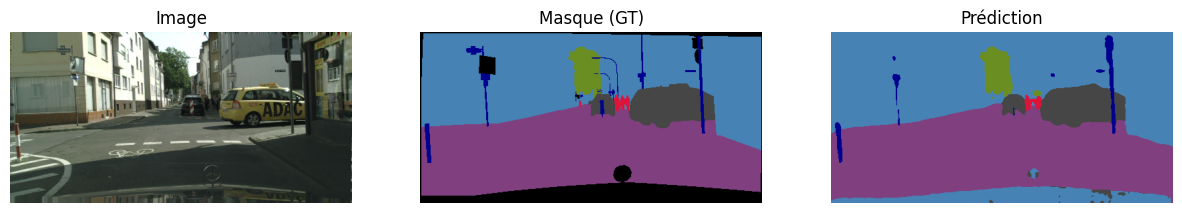

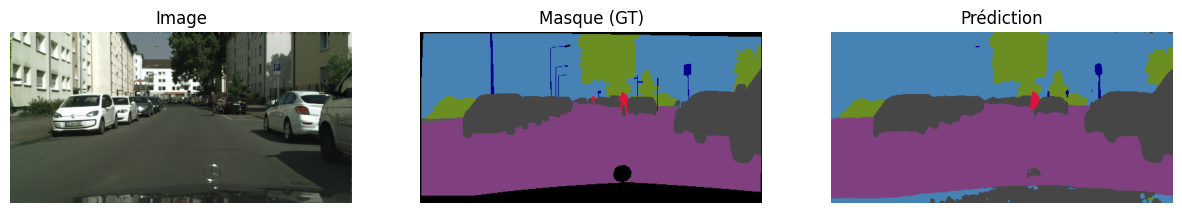

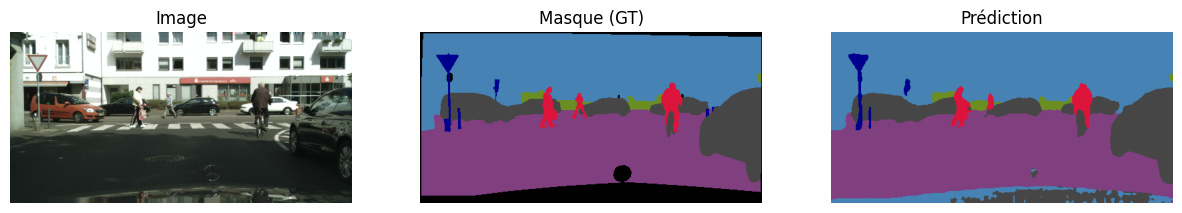

In [25]:
show_val_examples(model, processor, val_loader, num_examples=3)